In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
import scipy.optimize as spo
import scipy.special as sps

In [2]:
#This function takes a 3d array of (size along each dimension = N_side) poisson values of lamda = n_bar and the desired
# power spectrum pk_cl and returns another 3d array of the same dimension with the n(x) following pk_cl(k)

def GonzNuevo(box_p, N_side, L_side, n_bar, pk_cl, k_for_P, pseudo_fact):
    #Now pixel size of the box
    del_x = L_side/(N_side - 1)

    #Now let's get the density contrast
    box_delx = (box_p - n_bar)/n_bar

    #Now let's take the fourier transform of box_delx to get box_delk
    box_delk = pseudo_fact * np.fft.fftn(box_delx, norm='ortho')

    temp_factor = np.power(del_x * np.sqrt(N_side)/np.sqrt(2 * np.pi), 3)
    box_delk = temp_factor * box_delk

    #Getting the corresponding k values along 1d axis
    k_vals = 2 * np.pi * np.fft.fftfreq(N_side, d=del_x) # This is removed here---- , d= del_x)    

    #Power spectrum of the Poisson field box_delx
    #First I create a 3d array of same shape as box_delk, with values equal
    #to |k| value corresponding to same position in box_delk.
    temb_mesh = np.meshgrid(k_vals, k_vals, k_vals, indexing='ij')
    modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)

    #Now let's iterate through the k_for_P and find the index of modk_grid with k
    #that falls between and find power spectrum pk.
    pk = np.zeros(len(k_for_P)-1)
    for i, (k1, k2) in enumerate(zip(k_for_P[:-1], k_for_P[1:])):
        pk[i] = np.average(np.absolute(box_delk[np.where((modk_grid >= k1) & (modk_grid < k2))]) ** 2)
    
    box_vol = (N_side * del_x)**3
    pk = pk/box_vol

    #----------------------------------------------------------------------------------------------------
    #plotting the pks
    k_for_P_mid = (k_for_P[:-1] + k_for_P[1:])/2

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1.plot(k_for_P_mid, pk)
    ax2.plot(k_for_P_mid, pk_cl)

    ax1.set_xlabel('k')
    ax1.set_ylabel(r'$P_{pois}(k)$')
    ax2.set_xlabel('k')
    ax2.set_ylabel(r'$P_{cl}(k)$')
    #----------------------------------------------------------------------------------------------------
    
    #Make a new delk.
    box_delk_new = np.copy(box_delk)

    #modify the delk using the chosen power spectrum
    for i, (k1, k2) in enumerate(zip(k_for_P[:-1], k_for_P[1:])):
        temp_ind = np.where((modk_grid >= k1) & (modk_grid < k2))
        box_delk_new[temp_ind] = box_delk[temp_ind] * (np.sqrt(pk_cl[i] + pk[i])) / np.sqrt(pk[i])

    #Now we need to inverse fourier transfor box_delk_new to get box_delx_new
    box_delx_new = pseudo_fact * np.fft.ifftn(box_delk_new, norm='ortho')
    
    #Now again we have to add the factors
    del_k = 2 * np.pi/(N_side * del_x)
    temp_factor = np.power(del_k * np.sqrt(N_side)/np.sqrt(2 * np.pi), 3)
    box_delx_new = temp_factor * box_delx_new

    #Now to get the new n(x)
    #box_GN = np.asarray(np.round(n_bar * (1 + box_delx_new)), dtype='int64')
    box_GN = n_bar * (1 + box_delx_new) #np.where(box_delx_new<0, 0, box_delx_new))  #I have made all the negative values in box_delx_new to 0


    #-------------------------------------------------------------------------------------------------------
    #finding the new power spectrum
    pk_new = np.zeros(len(k_for_P)-1)
    for i, (k1, k2) in enumerate(zip(k_for_P[:-1], k_for_P[1:])):
        pk_new[i] = np.average(np.absolute(box_delk_new[np.where((modk_grid >= k1) & (modk_grid < k2))]) ** 2)
    
    pk_new = pk_new/box_vol

    #plotting the new psd vs the given one
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.plot(k_for_P_mid, pk_new, label=r'$P_{new}(k)$')
    ax1.plot(k_for_P_mid, pk_cl, label=r'$P_{cl}(k)$')
    ax1.set_xlabel('k')
    ax1.set_ylabel(r'$P(k)$')
    ax1.legend()
    ax2.plot(k_for_P_mid, pk_new-pk_cl, label=r'$P_{new}(k) - P_{cl}(k)$')
    ax2.set_xlabel('k')
    ax2.legend()
    #-------------------------------------------------------------------------------------------------------

    return box_GN

## Where it all begins

In [77]:
#Let's create a well defined box to hold the number of particles, box_p. 
N_side = 32
#Choose the mean number of particles, n_bar
n_bar = 5
#Choose the total physical length of the box
L_side = 31
#Now pixel size of the box
del_x = L_side/(N_side - 1)

#Populate box_p with number of particles drawn from Poisson with mean n_bar.
box_p = np.random.poisson(lam=n_bar, size=(N_side, N_side, N_side))

#Lets make the k's needed for the power spectrum.
k_min = 0 #2 * np.pi/(N_side * del_x) # changing minimum to 0 to see the effect
k_max = 2 * np.pi/(2 * del_x) * np.sqrt(3)#Changing the max k value to match the max in k grid.
assert (N_side % 2 == 0)
k_for_P = np.linspace(k_min, k_max, N_side//2 + 4)

#Now we have to make a desired power spectrum pk_cl
delta_of_k = 1.2
const_of_k = 1
k_for_P_mid = (k_for_P[:-1] + k_for_P[1:])/2
pk_cl = np.power(const_of_k * k_for_P_mid, -delta_of_k)

#This is a pseudo factor that i give to observe the effect of factor in 2pcf and box_GN distribution
pseudo_fact = 1

box_GN = GonzNuevo(box_p, N_side, L_side, n_bar, pk_cl, k_for_P, pseudo_fact)
plt.close('all')

## 2pcf measurement

In [78]:
#Let me make another box, which we will fill with Poisson drawn numbers.
#This will be used as the random catalog in our analysis.
N_side_r = N_side
n_bar_r = n_bar

box_r = np.random.poisson(lam=n_bar_r, size=(N_side_r, N_side_r, N_side_r))

#Now we can find the correlation function of box_GN. Using the same way.
bins = np.arange(1, N_side)
x1, y1, z1 = np.asarray(np.meshgrid(np.arange(N_side), np.arange(N_side), np.arange(N_side), indexing='xy'), dtype='float')
x1 = x1.flatten()
y1 = y1.flatten()
z1 = z1.flatten()
weights1 = np.asarray(box_GN.flatten(), dtype='float')

result_DD_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, weight_type='pair_product', periodic=False, output_ravg=True)

#Lets find similarly the DR and RR.
weights2 = np.asarray(box_r.flatten(), dtype='float')
x_r, y_r, z_r = np.asarray(np.meshgrid(np.arange(N_side_r), np.arange(N_side_r), np.arange(N_side_r), indexing='xy'), dtype='float')
x_r = x_r.flatten()
y_r = y_r.flatten()
z_r = z_r.flatten()
result_RR_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x_r, Y1 = y_r, Z1 = z_r, weights1 = weights2, weight_type='pair_product', periodic=False, output_ravg=True)

result_DR_GN = DD(autocorr=0, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, X2 = x_r, Y2 = y_r, Z2 = z_r, weights2 = weights2, \
               weight_type='pair_product', periodic=False, output_ravg=True)

#Now with DD, RR and DR that we obtained, we will find the xi(r), two point correlation function.
#We need normalisation also, which is the total number of pairs.
DD_count_GN = (result_DD_GN['npairs']*result_DD_GN['weightavg'])/2
DR_count_GN = result_DR_GN['npairs']*result_DR_GN['weightavg']
RR_count_GN = (result_RR_GN['npairs']*result_RR_GN['weightavg'])/2
DD_total_GN = (np.sum(weights1) * (np.sum(weights1) - 1))/2
RR_total_GN = (np.sum(weights2) * (np.sum(weights2) - 1))/2
DR_total_GN = (np.sum(weights1) * np.sum(weights2))

Xi_GN = (DD_count_GN/DD_total_GN - 2 * DR_count_GN/DR_total_GN + RR_count_GN/RR_total_GN)/(RR_count_GN/RR_total_GN)

/tmp/ipykernel_1758806/4187650135.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  weights1 = np.asarray(box_GN.flatten(), dtype='float')


k_for_P is :  [0.         0.28638937 0.57277875 0.85916812 1.14555749 1.43194687
 1.71833624 2.00472561 2.29111499 2.57750436 2.86389373 3.15028311
 3.43667248 3.72306185 4.00945123 4.2958406  4.58222997 4.86861935
 5.15500872 5.44139809]
k_for_P_mid is :  [0.14319469 0.42958406 0.71597343 1.00236281 1.28875218 1.57514155
 1.86153093 2.1479203  2.43430967 2.72069905 3.00708842 3.29347779
 3.57986717 3.86625654 4.15264591 4.43903529 4.72542466 5.01181403
 5.29820341]


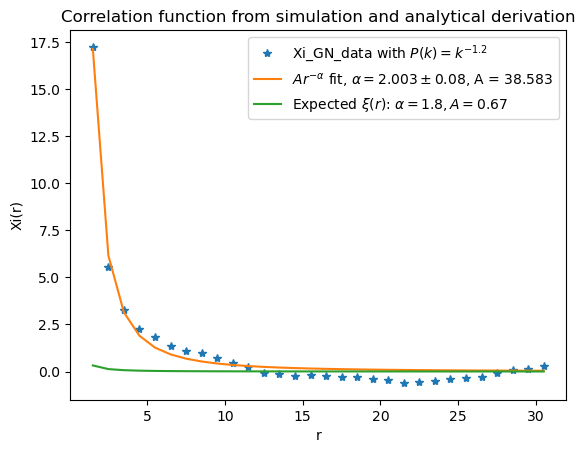

In [79]:
#Fitting the Xi_GN with a power law function to check what degree of correlation we get
def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)

r_bins = bins * del_x
r_mid = (r_bins[:-1] + r_bins[1:])/2

popt, pcov = spo.curve_fit(pow_func, r_mid, Xi_GN)

fig, ax = plt.subplots()

ax.plot(r_mid, Xi_GN, '*', label = r"Xi_GN_data with $P(k) = k^{{-{}}}$".format(delta_of_k))
ax.plot(r_mid, pow_func(r_mid, popt[0], popt[1]), label=r'$Ar^{{-\alpha}}$ fit, $\alpha = {}\pm{}$, A = {}'.format(np.round(popt[1],3),np.round(np.sqrt(pcov[1,1]), 2), np.round(popt[0],3)))
ax.set_xlabel('r')
ax.set_ylabel('Xi(r)')

#Expected correlation function
alpha_expect = 3 - delta_of_k
A_expect = (sps.gamma(alpha_expect/2))/ (const_of_k * np.power(2, 1 - alpha_expect/2) * sps.gamma((3 - alpha_expect)/2))
ax.plot(r_mid, pow_func(r_mid, A_expect, alpha_expect), label=r"Expected $\xi(r)$: $\alpha = {}, A = {}$".format(np.round(alpha_expect,3), np.round(A_expect,3)))
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()
ax.set_title("Correlation function from simulation and analytical derivation")

print("k_for_P is : ",k_for_P)
print("k_for_P_mid is : ", k_for_P_mid)

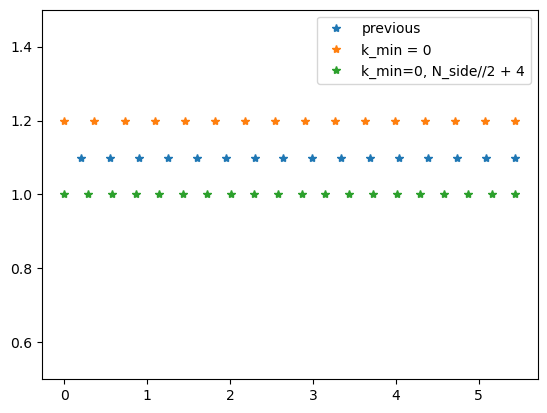

In [76]:
##Why k bin is so impactful on 2pcf

k_min = 2 * np.pi/(N_side * del_x) # changing minimum to 0 to see the effect
k_max = 2 * np.pi/(2 * del_x) * np.sqrt(3)#Changing the max k value to match the max in k grid.
k_for_P1 = np.linspace(k_min, k_max, N_side//2)
k_for_P2 = np.linspace(0, k_max, N_side//2)
k_for_P3 = np.linspace(0, k_max, N_side//2 + 4)

plt.plot(k_for_P1, np.ones_like(k_for_P1)+0.1, '*', label = "previous")
plt.plot(k_for_P2, np.ones_like(k_for_P2)+0.2, '*', label = "k_min = 0")
plt.plot(k_for_P3, np.ones_like(k_for_P3), '*', label = "k_min=0, N_side//2 + 4")
plt.ylim(0.5, 1.5)
plt.legend()

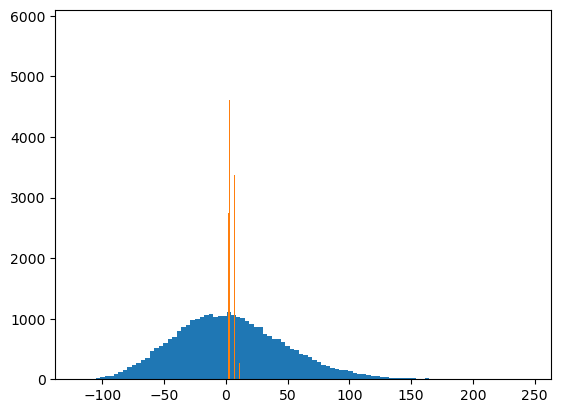

In [80]:
plt.hist(np.real(box_GN.flatten()), bins=100);
plt.hist(box_p.flatten(), bins=100);

## Doing analysis on big dimensional box

In [3]:
#Let's create a well defined box to hold the number of particles, box_p. 
N_side = 512
#Choose the mean number of particles, n_bar
n_bar = 5
#Choose the total physical length of the box
L_side = 31
#Now pixel size of the box
del_x = L_side/(N_side - 1)

#Populate box_p with number of particles drawn from Poisson with mean n_bar.
big_box_p = np.random.poisson(lam=n_bar, size=(N_side, N_side, N_side))

#Lets make the k's needed for the power spectrum.
k_min = 0 #2 * np.pi/(N_side * del_x) # changing minimum to 0 to see the effect
k_max = 2 * np.pi/(2 * del_x) * np.sqrt(3)#Changing the max k value to match the max in k grid.
assert (N_side % 2 == 0)
k_for_P = np.linspace(k_min, k_max, N_side//2 + 4)

#Now we have to make a desired power spectrum pk_cl
delta_of_k = 2.0
const_of_k = 1
k_for_P_mid = (k_for_P[:-1] + k_for_P[1:])/2
pk_cl = np.power(const_of_k * k_for_P_mid, -delta_of_k)

#This is a pseudo factor that i give to observe the effect of factor in 2pcf and box_GN distribution
pseudo_fact = 1

big_box_GN = GonzNuevo(big_box_p, N_side, L_side, n_bar, pk_cl, k_for_P, pseudo_fact)
plt.close('all')

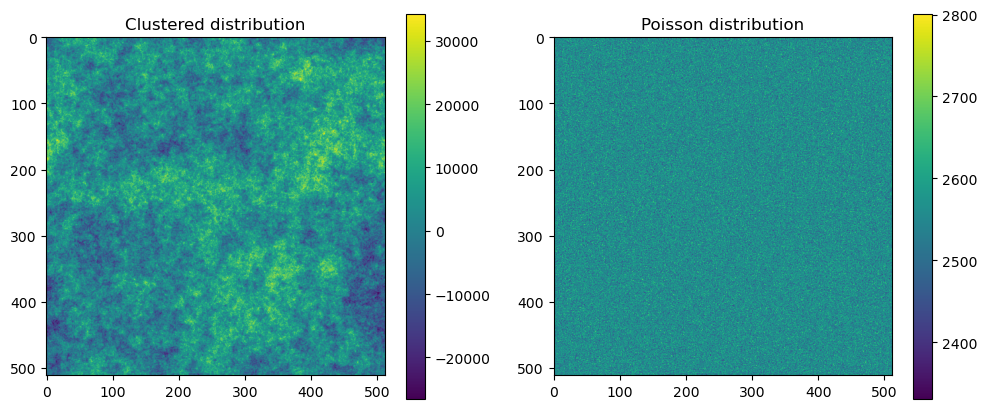

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
im = ax1.imshow(np.sum(np.real(big_box_GN), axis=0))
ax1.set_title("Clustered distribution")
plt.colorbar(im)

im2 = ax2.imshow(np.sum(big_box_p, axis=0))
ax2.set_title("Poisson distribution")
plt.colorbar(im2)

(-50.0, 50.0)

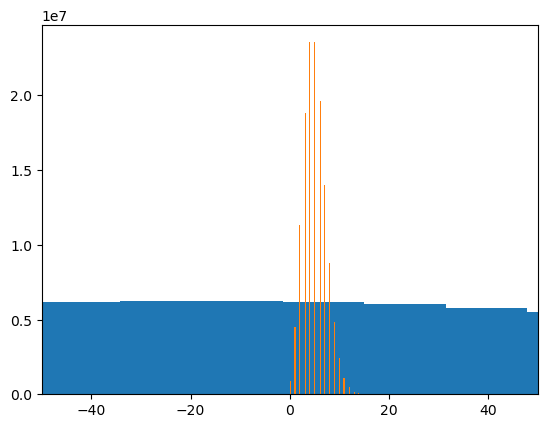

In [86]:
plt.hist(np.real(big_box_GN.flatten()), bins=100);
plt.hist(big_box_p.flatten(), bins=100);
plt.xlim(-50,50)

In [9]:
sub_box_GN = np.copy(np.real(big_box_GN[:32, :32, :32]))
sub_box_mean = np.average(sub_box_GN)

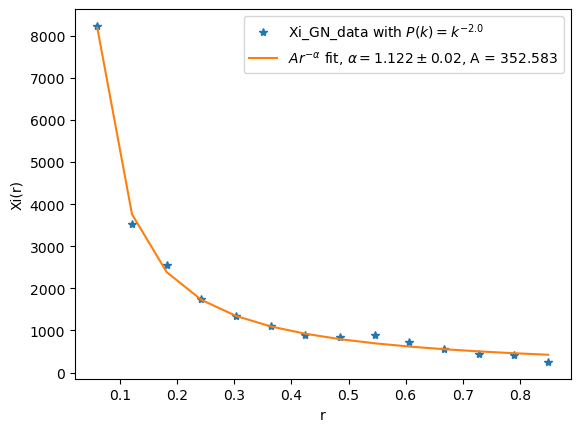

In [12]:
# I am finding the 2pcf along axis 0 here
dim = np.shape(sub_box_GN)[0]
temp_x_min = 1
temp_x_max = 15
temp_corr = np.zeros(temp_x_max - temp_x_min)
for i, temp_x in enumerate(range(temp_x_min, temp_x_max)):
    temp_corr[i] = np.average((sub_box_GN[:,:dim-temp_x,:]-sub_box_mean) * (sub_box_GN[:,temp_x:,:]-sub_box_mean))


def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)
temp_x = del_x * np.arange(temp_x_min, temp_x_max)

temp_popt, temp_pcov = spo.curve_fit(pow_func, temp_x, temp_corr)

plt.plot(temp_x, temp_corr, '*', label = r"Xi_GN_data with $P(k) = k^{{-{}}}$".format(delta_of_k))
plt.plot(temp_x, pow_func(temp_x, temp_popt[0], temp_popt[1]), label=r'$Ar^{{-\alpha}}$ fit, $\alpha = {}\pm{}$, A = {}'.format(np.round(temp_popt[1],3),np.round(np.sqrt(temp_pcov[1,1]), 2), \
                                                                                                                    np.round(temp_popt[0],3)))
plt.xlabel('r')
plt.ylabel('Xi(r)')
plt.legend()

In [10]:
N_side = 32
n_bar = 5

#Let me make another box, which we will fill with Poisson drawn numbers.
#This will be used as the random catalog in our analysis.
N_side_r = N_side
n_bar_r = n_bar

box_r = np.random.poisson(lam=n_bar_r, size=(N_side_r, N_side_r, N_side_r))

#Now we can find the correlation function of box_GN. Using the same way.
bins = np.arange(1, N_side)
x1, y1, z1 = np.asarray(np.meshgrid(np.arange(N_side), np.arange(N_side), np.arange(N_side), indexing='xy'), dtype='float')
x1 = x1.flatten()
y1 = y1.flatten()
z1 = z1.flatten()
weights1 = np.asarray(sub_box_GN.flatten(), dtype='float')

result_DD_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, weight_type='pair_product', periodic=False, output_ravg=True)

#Lets find similarly the DR and RR.
weights2 = np.asarray(box_r.flatten(), dtype='float')
x_r, y_r, z_r = np.asarray(np.meshgrid(np.arange(N_side_r), np.arange(N_side_r), np.arange(N_side_r), indexing='xy'), dtype='float')
x_r = x_r.flatten()
y_r = y_r.flatten()
z_r = z_r.flatten()
result_RR_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x_r, Y1 = y_r, Z1 = z_r, weights1 = weights2, weight_type='pair_product', periodic=False, output_ravg=True)

result_DR_GN = DD(autocorr=0, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, X2 = x_r, Y2 = y_r, Z2 = z_r, weights2 = weights2, \
               weight_type='pair_product', periodic=False, output_ravg=True)

#Now with DD, RR and DR that we obtained, we will find the xi(r), two point correlation function.
#We need normalisation also, which is the total number of pairs.
DD_count_GN = (result_DD_GN['npairs']*result_DD_GN['weightavg'])/2
DR_count_GN = result_DR_GN['npairs']*result_DR_GN['weightavg']
RR_count_GN = (result_RR_GN['npairs']*result_RR_GN['weightavg'])/2
DD_total_GN = (np.sum(weights1) * (np.sum(weights1) - 1))/2
RR_total_GN = (np.sum(weights2) * (np.sum(weights2) - 1))/2
DR_total_GN = (np.sum(weights1) * np.sum(weights2))

Xi_GN = (DD_count_GN/DD_total_GN - 2 * DR_count_GN/DR_total_GN + RR_count_GN/RR_total_GN)/(RR_count_GN/RR_total_GN)

k_for_P is :  [ 0.          0.34631392  0.69262783  1.03894175  1.38525566  1.73156958
  2.07788349  2.42419741  2.77051132  3.11682524  3.46313915  3.80945307
  4.15576698  4.5020809   4.84839481  5.19470873  5.54102264  5.88733656
  6.23365047  6.57996439  6.9262783   7.27259222  7.61890614  7.96522005
  8.31153397  8.65784788  9.0041618   9.35047571  9.69678963 10.04310354
 10.38941746 10.73573137 11.08204529 11.4283592  11.77467312 12.12098703
 12.46730095 12.81361486 13.15992878 13.50624269 13.85255661 14.19887052
 14.54518444 14.89149835 15.23781227 15.58412619 15.9304401  16.27675402
 16.62306793 16.96938185 17.31569576 17.66200968 18.00832359 18.35463751
 18.70095142 19.04726534 19.39357925 19.73989317 20.08620708 20.432521
 20.77883491 21.12514883 21.47146274 21.81777666 22.16409057 22.51040449
 22.85671841 23.20303232 23.54934624 23.89566015 24.24197407 24.58828798
 24.9346019  25.28091581 25.62722973 25.97354364 26.31985756 26.66617147
 27.01248539 27.3587993  27.70511322 28

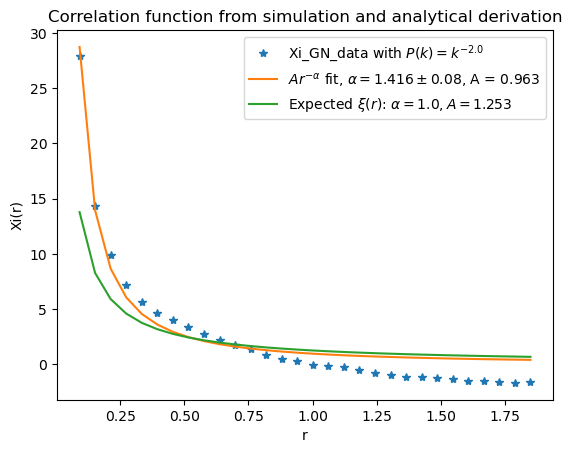

In [11]:
#Fitting the Xi_GN with a power law function to check what degree of correlation we get
def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)

r_bins = bins * del_x
r_mid = (r_bins[:-1] + r_bins[1:])/2

popt, pcov = spo.curve_fit(pow_func, r_mid, Xi_GN)

fig, ax = plt.subplots()

ax.plot(r_mid, Xi_GN, '*', label = r"Xi_GN_data with $P(k) = k^{{-{}}}$".format(delta_of_k))
ax.plot(r_mid, pow_func(r_mid, popt[0], popt[1]), label=r'$Ar^{{-\alpha}}$ fit, $\alpha = {}\pm{}$, A = {}'.format(np.round(popt[1],3),np.round(np.sqrt(pcov[1,1]), 2), np.round(popt[0],3)))
ax.set_xlabel('r')
ax.set_ylabel('Xi(r)')

#Expected correlation function
alpha_expect = 3 - delta_of_k
A_expect = (sps.gamma(alpha_expect/2))/ (const_of_k * np.power(2, 1 - alpha_expect/2) * sps.gamma((3 - alpha_expect)/2))
ax.plot(r_mid, pow_func(r_mid, A_expect, alpha_expect), label=r"Expected $\xi(r)$: $\alpha = {}, A = {}$".format(np.round(alpha_expect,3), np.round(A_expect,3)))
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()
ax.set_title("Correlation function from simulation and analytical derivation")

print("k_for_P is : ",k_for_P)
print("k_for_P_mid is : ", k_for_P_mid)